# Creating and Evaluating Predictors: Part 1 - Target Time Series

This notebook will build off of the earlier data processing that was performed in the validation sessions. If you have not completed that part yet, go back to [1.Validate_and_Import_Target_Time_Series_Data.ipynb](1.Validate_and_Import_Target_Time_Series_Data.ipynb) and complete it first before resuming.

At this point you have target-time-series data loaded into Amazon Forecast inside a Dataset Group, this is what is required to use all of the models within Amazon Forecast. As an initial exploration we will evaluate the results from ARIMA, Prophet, and CNN-QR. We could have also included ETS or DeepAR+, but have left them out for time constraints. Similarly NPTS was left out as it specializes on spiky data or large gaps which our dataset does not have.

The very first thing to do is start with our imports, establish a connection to the Forecast service, and then restore our variables from before. The cells below will do that.

In [1]:
import boto3
from time import sleep
import subprocess
import pandas as pd
import json
import time
import pprint
import numpy as np
import util
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import matplotlib.dates as mdates
from IPython.display import Markdown

In [2]:
with open('/opt/ml/metadata/resource-metadata.json') as notebook_info:
    data = json.load(notebook_info)
    resource_arn = data['ResourceArn']
    region = resource_arn.split(':')[3]
print(region)

ap-southeast-1


In [3]:
session = boto3.Session(region_name=region)
forecast = session.client(service_name='forecast')
forecast_query = session.client(service_name='forecastquery')

In [4]:
%store -r

In [ ]:
s3 = boto3.resource("s3")
poc_bucket = s3.Bucket(bucket_name)

## Creating and Training Predictors
 
Given that that our data is hourly and we want to generate a forecast on the hour, Forecast limits us to a horizon of 500 of whatever the slice is. This means we will be able to predict about 20 days into the future.

The cells below will define a few variables to be used with all of our models. Then there will be an API call to create each `Predictor` where they are based on ARIMA, Prophet, and CNN-QR respectively.


In [5]:
forecast_horizon = 240
num_backtest_windows = 1
backtest_window_offset = 240
forecast_frequency = "H"

In [6]:
arima_algorithm_arn = "arn:aws:forecast:::algorithm/ARIMA"
prophet_algorithm_arn = "arn:aws:forecast:::algorithm/Prophet"
cnnqr_algorithm_arn = "arn:aws:forecast:::algorithm/CNN-QR"

### ARIMA

In [7]:
# ARIMA Specifics
arima_predictor_name = project + "_arima_algo_1"

In [8]:
# Build ARIMA:
arima_create_predictor_response = forecast.create_predictor(
    PredictorName=arima_predictor_name,
    AlgorithmArn=arima_algorithm_arn,
    ForecastHorizon=forecast_horizon,
    PerformAutoML=False,
    PerformHPO=False,
    EvaluationParameters={
        "NumberOfBacktestWindows": num_backtest_windows,
        "BackTestWindowOffset": backtest_window_offset,
    },
    InputDataConfig={
        "DatasetGroupArn": datasetGroupArn,
        "SupplementaryFeatures": [
            { "Name": "holiday", "Value": "US" },
        ],
    },
    FeaturizationConfig={
        "ForecastFrequency": forecast_frequency,
        "Featurizations": [
            {
                "AttributeName": "target_value",
                "FeaturizationPipeline": [
                    {
                        "FeaturizationMethodName": "filling",
                        "FeaturizationMethodParameters": {
                            "frontfill": "none",
                            "middlefill": "zero",
                            "backfill": "zero",
                        },
                    },
                ],
            },
        ],
    },
)


### Prophet

In [9]:
# Prophet Specifics
prophet_predictor_name = project + "_prophet_algo_1"

In [10]:
# Build Prophet:
prophet_create_predictor_response = forecast.create_predictor(
    PredictorName=prophet_predictor_name,
    AlgorithmArn=prophet_algorithm_arn,
    ForecastHorizon=forecast_horizon,
    PerformAutoML=False,
    PerformHPO=False,
    EvaluationParameters={
        "NumberOfBacktestWindows": num_backtest_windows,
        "BackTestWindowOffset": backtest_window_offset,
    },
    InputDataConfig={
        "DatasetGroupArn": datasetGroupArn,
        "SupplementaryFeatures": [
            { "Name": "holiday", "Value": "US" },
        ],
    },
    FeaturizationConfig={
        "ForecastFrequency": forecast_frequency, 
        "Featurizations": [
            {
                "AttributeName": "target_value",
                "FeaturizationPipeline": [
                    {
                        "FeaturizationMethodName": "filling",
                        "FeaturizationMethodParameters": {
                            "frontfill": "none",
                            "middlefill": "zero",
                            "backfill": "zero",
                        },
                    },
                ],
            },
        ],
    },
)


### CNN-QR

In [11]:
# CNN-QR Specifics
cnnqr_predictor_name = project + "_cnnqr_algo_1"

In [12]:
# Build CNN-QR:
cnnqr_create_predictor_response = forecast.create_predictor(
    PredictorName=cnnqr_predictor_name,
    AlgorithmArn=cnnqr_algorithm_arn,
    ForecastHorizon=forecast_horizon,
    PerformAutoML=False,
    PerformHPO=False,
    EvaluationParameters={
        "NumberOfBacktestWindows": num_backtest_windows,
        "BackTestWindowOffset": backtest_window_offset,
    },
    InputDataConfig={
        "DatasetGroupArn": datasetGroupArn,
        "SupplementaryFeatures": [
            { "Name": "holiday", "Value": "US" },
        ],
    },
    FeaturizationConfig={
        "ForecastFrequency": forecast_frequency, 
        "Featurizations": [
            {
                "AttributeName": "target_value",
                "FeaturizationPipeline": [
                    {
                        "FeaturizationMethodName": "filling",
                        "FeaturizationMethodParameters": {
                            "frontfill": "none",
                            "middlefill": "zero",
                            "backfill": "zero",
                        },
                    },
                ],
            },
        ],
    },
)


Normally in our notebooks we would have a while loop that polls for each of these to determine the status of the models in training. The cell below will poll for the ARNs of each and return when they are all available so you can move onto the next step.

In [ ]:
in_progress_predictors = [
    arima_create_predictor_response["PredictorArn"],
    prophet_create_predictor_response["PredictorArn"],
    cnnqr_create_predictor_response["PredictorArn"],
]

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    for predictor_arn in in_progress_predictors:
        predictor_response = forecast.describe_predictor(PredictorArn=predictor_arn)
        status = predictor_response["Status"]

        if status == "ACTIVE":
            print("Build succeeded for {}".format(predictor_arn))
            in_progress_predictors.remove(predictor_arn)
        elif status == "CREATE FAILED":
            print("Build failed for {}".format(predictor_arn))
            in_progress_predictors.remove(predictor_arn)

    n_in_progress = len(in_progress_predictors)
    if n_in_progress <= 0:
        break
    else:
        print("{} predictor builds still in progress".format(n_in_progress))
        
    time.sleep(60)

## Examining the Predictors

Once each of the Predictors is in an `Active` state you can get metrics about it to better understand its accuracy and behavior. These are computed based on the hold out periods we defined when building the Predictor. The metrics are meant to guide our decisions when we use a particular Predictor to generate a forecast

### ARIMA

ARIMA is one of the gold standards for time series forecasting. This algorithm is not particularly sophisticated but it is reliable and can help us understand a baseline of performance. To note it does not really understand seasonality very well and it does not support any item metadata or related time series information. Due to that we will explore it here but not after adding other datasets.

In [14]:
# ARIMA Metrics
arima_arn = arima_create_predictor_response["PredictorArn"]
arima_metrics = forecast.get_accuracy_metrics(PredictorArn=arima_arn)
pp = pprint.PrettyPrinter()
pp.pprint(arima_metrics)
arima_RMSEs = util.extract_json_values(arima_metrics, "RMSE")
markdown_results = []
markdown_results.append(arima_RMSEs[0])
arima_loss_values = util.extract_json_values(arima_metrics, "LossValue")
markdown_results = markdown_results + arima_loss_values[::-1][:3]

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/ARIMA',
                                 'TestWindows': [{'EvaluationType': 'SUMMARY',
                                                  'Metrics': {'RMSE': 1948.4689583194158,
                                                              'WeightedQuantileLosses': [{'LossValue': 0.2859468346413724,
                                                                                          'Quantile': 0.9},
                                                                                         {'LossValue': 0.47151931283055987,
                                                                                          'Quantile': 0.5},
                                                                                         {'LossValue': 0.17040618676072272,
                                                                                          'Quantile': 0.1}]}},
                                              

In [15]:
Markdown("""
Overall our RMSE is {0[0]}... This will help you rank your other predictors where you look to see a 
reduction in RMSE. Overall performance looks like this:

| Predictor | RMSE               | 10%                 | 50%                 | 90%                |
|-----------|--------------------|---------------------|---------------------|--------------------|
| ARIMA     | {0[0]}             | {0[1]}              | {0[2]}              | {0[3]}             |

Again these particular values will help us evaluate the other predictors.
""".format(markdown_results))


Overall our RMSE is 1948.4689583194158... This will help you rank your other predictors where you look to see a 
reduction in RMSE. Overall performance looks like this:

| Predictor | RMSE               | 10%                 | 50%                 | 90%                |
|-----------|--------------------|---------------------|---------------------|--------------------|
| ARIMA     | 1948.4689583194158             | 0.17040618676072272              | 0.47151931283055987              | 0.2859468346413724             |

Again these particular values will help us evaluate the other predictors.


### Prophet

Same as ARIMA, now you should look at the metrics from it.

In [16]:
# Prophet Metrics
prophet_arn = prophet_create_predictor_response["PredictorArn"]
prophet_metrics = forecast.get_accuracy_metrics(PredictorArn=prophet_arn)
pp = pprint.PrettyPrinter()
pp.pprint(prophet_metrics)
prophet_RMSEs = util.extract_json_values(prophet_metrics, "RMSE")
markdown_results.append(prophet_RMSEs[0])
prophet_loss_values = util.extract_json_values(prophet_metrics, "LossValue")
markdown_results = markdown_results + prophet_loss_values[::-1][:3]

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/Prophet',
                                 'TestWindows': [{'EvaluationType': 'SUMMARY',
                                                  'Metrics': {'RMSE': 1913.7525026234214,
                                                              'WeightedQuantileLosses': [{'LossValue': 0.27147606892276877,
                                                                                          'Quantile': 0.9},
                                                                                         {'LossValue': 0.48217453337132055,
                                                                                          'Quantile': 0.5},
                                                                                         {'LossValue': 0.18862451581998443,
                                                                                          'Quantile': 0.1}]}},
                                           

In [17]:
Markdown("""
Here you see an RMSE of {0[4]}.... Just a bit lesser than ARIMA, but at this point Prophet has 
not had a chance to use any of its abilities to integrate related time series information. 
Prophet's performance compared to ARIMA is:

| Predictor | RMSE               | 10%                 | 50%                 | 90%                |
|-----------|--------------------|---------------------|---------------------|--------------------|
| ARIMA     | {0[0]}             | {0[1]}              | {0[2]}              | {0[3]}             |
| Prophet   | {0[4]}             | {0[5]}              | {0[6]}              | {0[7]}             |

What this tells us is that when querying the 90% quantile we see less of an error from Prophet, but we see a 
bit worse performance in the 10% and 50% quantile. Next will be DeepAR.
""".format(markdown_results))


Here you see an RMSE of 1913.7525026234214.... Just a bit lesser than ARIMA, but at this point Prophet has 
not had a chance to use any of its abilities to integrate related time series information. 
Prophet's performance compared to ARIMA is:

| Predictor | RMSE               | 10%                 | 50%                 | 90%                |
|-----------|--------------------|---------------------|---------------------|--------------------|
| ARIMA     | 1948.4689583194158             | 0.17040618676072272              | 0.47151931283055987              | 0.2859468346413724             |
| Prophet   | 1913.7525026234214             | 0.18862451581998443              | 0.48217453337132055              | 0.27147606892276877             |

What this tells us is that when querying the 90% quantile we see less of an error from Prophet, but we see a 
bit worse performance in the 10% and 50% quantile. Next will be DeepAR.


### CNN-QR

Same as Prophet and ARIMA, now you should look at the metrics from it.

In [18]:
# CNN-QR Metrics
cnnqr_arn = cnnqr_create_predictor_response["PredictorArn"]
cnnqr_metrics = forecast.get_accuracy_metrics(PredictorArn=cnnqr_arn)
pp = pprint.PrettyPrinter()
pp.pprint(cnnqr_metrics)
cnnqr_RMSEs = util.extract_json_values(cnnqr_metrics, "RMSE")
markdown_results.append(cnnqr_RMSEs[0])
cnnqr_loss_values = util.extract_json_values(cnnqr_metrics, "LossValue")
markdown_results = markdown_results + cnnqr_loss_values[::-1][:3]

{'PredictorEvaluationResults': [{'AlgorithmArn': 'arn:aws:forecast:::algorithm/CNN-QR',
                                 'TestWindows': [{'EvaluationType': 'SUMMARY',
                                                  'Metrics': {'RMSE': 1610.8844907519385,
                                                              'WeightedQuantileLosses': [{'LossValue': 0.28427277119694144,
                                                                                          'Quantile': 0.9},
                                                                                         {'LossValue': 0.36146906723884054,
                                                                                          'Quantile': 0.5},
                                                                                         {'LossValue': 0.2538638986019722,
                                                                                          'Quantile': 0.1}]}},
                                             

In [19]:
Markdown("""
Here you see an RMSE of {0[8]}... Lesser and better than both ARIMA and Prophet. Diving a bit more deeply we see:

| Predictor | RMSE               | 10%                 | 50%                 | 90%                |
|-----------|--------------------|---------------------|---------------------|--------------------|
| ARIMA     | {0[0]}             | {0[1]}              | {0[2]}              | {0[3]}             |
| Prophet   | {0[4]}             | {0[5]}              | {0[6]}              | {0[7]}             |
| CNN-QR    | {0[8]}             | {0[9]}              | {0[10]}             | {0[11]}            |

We are now seeing major improvements in accuracy for the 50% and 90% quantiles with a bit worse performance on the 10%. 
To explore what this all looks like in a visual format we will now create a Forecast with each Predictor and then 
export it to s3 where we can download and explore the results.
""".format(markdown_results))


Here you see an RMSE of 1610.8844907519385... Lesser and better than both ARIMA and Prophet. Diving a bit more deeply we see:

| Predictor | RMSE               | 10%                 | 50%                 | 90%                |
|-----------|--------------------|---------------------|---------------------|--------------------|
| ARIMA     | 1948.4689583194158             | 0.17040618676072272              | 0.47151931283055987              | 0.2859468346413724             |
| Prophet   | 1913.7525026234214             | 0.18862451581998443              | 0.48217453337132055              | 0.27147606892276877             |
| DeepAR+   | 1610.8844907519385             | 0.2538638986019722              | 0.36146906723884054             | 0.28427277119694144            |

We are now seeing major improvements in accuracy for the 50% and 90% quantiles with a bit worse performance on the 10%. 
To explore what this all looks like in a visual format we will now create a Forecast with each Predictor and then 
export it to s3 where we can download and explore the results.


## Creating and Exporting Forecasts

Inside Amazon Forecast a Forecast is a rendered collection of all of your items, at every time interval, for all selected quantiles, for your given forecast horizon. This process takes the Predictor you just created and uses it to generate these inferences and to store them in a useful state. Once a Forecast exists within the service you can query it and obtain a JSON response or use another API call to export it to a CSV that is stored in S3. 

This tutorial will focus on the S3 Export as that is often an easy way to manually explore the data with many tools.

These again will take some time to complete after you have executed the cells so explore the console to see when they have completed.

To do that visit the Amazon Forecast Service page, then clck your Dataset Group, and then click `Forecasts` on the left. They will say `Create in progress...` initially and then `Active` when ready for export.

In [20]:
# ARIMA
arima_forecast_name = project + "_arima_algo_forecast"
arima_create_forecast_response = forecast.create_forecast(
    ForecastName=arima_forecast_name,
    PredictorArn=arima_arn,
)
arima_forecast_arn = arima_create_forecast_response["ForecastArn"]

In [21]:
# Prophet
prophet_forecast_name = project + "_prophet_algo_forecast"
prophet_create_forecast_response = forecast.create_forecast(
    ForecastName=prophet_forecast_name,
    PredictorArn=prophet_arn,
)
prophet_forecast_arn = prophet_create_forecast_response["ForecastArn"]

In [22]:
# CNN-QR
cnnqr_forecast_name = project + "_cnnqr_algo_forecast"
cnnqr_create_forecast_response = forecast.create_forecast(
    ForecastName=cnnqr_forecast_name,
    PredictorArn=cnnqr_arn,
)
cnnqr_forecast_arn = cnnqr_create_forecast_response["ForecastArn"]

Again as you saw in the training step, you should poll until completion to know that you are ready to proceed to the next step. The cell below will do that.

In [ ]:
in_progress_forecasts = [
    arima_forecast_arn,
    prophet_forecast_arn,
    cnnqr_forecast_arn,
]

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    for forecast_arn in in_progress_forecasts:
        forecast_response = forecast.describe_forecast(ForecastArn=forecast_arn)
        status = forecast_response["Status"]

        if status == "ACTIVE":
            print("Build succeeded for {}".format(forecast_arn))
            in_progress_forecasts.remove(forecast_arn)
        elif status == "CREATE FAILED":
            print("Build failed for {}".format(forecast_arn))
            in_progress_forecasts.remove(forecast_arn)

    n_in_progress = len(in_progress_forecasts)
    if n_in_progress <= 0:
        break
    else:
        print("{} forecast builds still in progress".format(n_in_progress))

    time.sleep(60)


3 forecast builds still in progress
3 forecast builds still in progress
3 forecast builds still in progress
3 forecast builds still in progress
3 forecast builds still in progress
3 forecast builds still in progress
3 forecast builds still in progress
3 forecast builds still in progress
3 forecast builds still in progress
3 forecast builds still in progress
3 forecast builds still in progress
3 forecast builds still in progress
3 forecast builds still in progress
3 forecast builds still in progress
3 forecast builds still in progress
3 forecast builds still in progress
3 forecast builds still in progress
3 forecast builds still in progress
3 forecast builds still in progress
3 forecast builds still in progress
Build succeeded for arn:aws:forecast:ap-southeast-1:024103970757:forecast/forecast_poc_0rj4_arima_algo_forecast
2 forecast builds still in progress
2 forecast builds still in progress
Build succeeded for arn:aws:forecast:ap-southeast-1:024103970757:forecast/forecast_poc_0rj4_prop

Once they are `Active` you can start the export process. The code to do so is in the cells below. 

In [ ]:
arima_path = "s3://" + bucket_name + "/arima_1/"
arima_job_name = "ARIMAExport"
arima_export_response = forecast.create_forecast_export_job(
    ForecastExportJobName=arima_job_name,
    ForecastArn=arima_forecast_arn,
    Destination={
        "S3Config": {
            "Path": arima_path,
            "RoleArn": role_arn,
        },
    },
)
armia_export_arn = arima_export_response["ForecastExportJobArn"]

In [ ]:
prophet_path = "s3://" + bucket_name + "/prophet_1/"
prophet_job_name = "ProphetExport"
prophet_export_response = forecast.create_forecast_export_job(
    ForecastExportJobName=prophet_job_name,
    ForecastArn=prophet_forecast_arn,
    Destination={
        "S3Config": {
            "Path": prophet_path,
            "RoleArn": role_arn,
        },
    },
)
prophet_export_arn = prophet_export_response["ForecastExportJobArn"]

In [28]:
cnnqr_path = "s3://" + bucket_name + "/cnnqr_1/"
cnnqr_job_name = "CNNQRExport"
cnnqr_export_response = forecast.create_forecast_export_job(
    ForecastExportJobName=cnnqr_job_name,
    ForecastArn=cnnqr_forecast_arn,
    Destination={
        "S3Config": {
            "Path": cnnqr_path,
            "RoleArn": role_arn,
        },
    },
)
cnnqr_export_arn = cnnqr_export_response["ForecastExportJobArn"]

This exporting process is another one of those items that will take several minutes to complete. Once again, poll with the cell below then move on to the next section.

In [ ]:
in_progress_exports = [
    armia_export_arn,
    prophet_export_arn,
    cnnqr_export_arn,
]

max_time = time.time() + 3*60*60 # 3 hours
while time.time() < max_time:
    for export_arn in in_progress_exports:
        export_response = forecast.describe_forecast_export_job(ForecastExportJobArn=export_arn)
        status = export_response["Status"]
        if status == "ACTIVE":
            print("Export succeeded for {}".format(export_arn))
            in_progress_exports.remove(export_arn)
        elif status == "CREATE FAILED":
            print("Export failed for {}".format(export_arn))
            in_progress_exports.remove(export_arn)
    
    n_in_progress = len(in_progress_exports)
    if n_in_progress <= 0:
        break
    else:
        print("{} forecast exports still in progress".format(n_in_progress))
        
    time.sleep(60)

### Obtaining the Forecasts

At this point they are all exported into S3 but you need to obtain the results locally so we can explore them, the cells below will do that starting with ARIMA, then Prophet, and lastly CNN-QR.

In [35]:
# ARIMA
arima_filename = ""
arima_files = list(poc_bucket.objects.filter(Prefix="arima_1"))
for file in arima_files:
    # There will be a collection of CSVs if the forecast is large, modify this to go get them all
    if "csv" in file.key:
        arima_filename = file.key.split('/')[1]
        s3.Bucket(bucket_name).download_file(file.key, data_dir+"/"+arima_filename)
        break
print(arima_filename)

ARIMAExport_2020-08-22T07-09-14Z_part0.csv


In [36]:
# Prophet
prophet_filename = ""
prophet_files = list(poc_bucket.objects.filter(Prefix="prophet_1"))
for file in prophet_files:
    # There will be a collection of CSVs if the forecast is large, modify this to go get them all
    if "csv" in file.key:
        prophet_filename = file.key.split('/')[1]
        s3.Bucket(bucket_name).download_file(file.key, data_dir+"/"+prophet_filename)
        break
print(prophet_filename)

ProphetExport_2020-08-22T07-09-00Z_part0.csv


In [38]:
# CNN-QR
cnnqr_filename = ""
cnnqr_files = list(poc_bucket.objects.filter(Prefix="cnnqr_1"))
for file in cnnqr_files:
    # There will be a collection of CSVs if the forecast is large, modify this to go get them all
    if "csv" in file.key:
        cnnqr_filename = file.key.split('/')[1]
        s3.Bucket(bucket_name).download_file(file.key, data_dir+"/"+cnnqr_filename)
        break
print(cnnqr_filename)

CNNQRExport_2020-08-24T01-50-39Z_part0.csv


### ARIMA Validation

In [39]:
# ARIMA Eval
arima_predicts = pd.read_csv(data_dir+"/"+arima_filename)
arima_predicts.sample()

,item_id,date,p10,p50,p90
232,1,2018-01-10T16:00:00Z,3838.347336,6338.560679,8838.774021


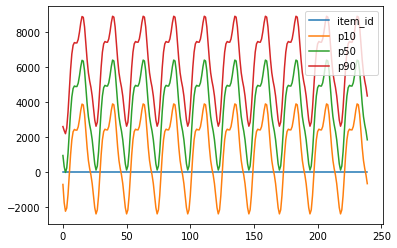

In [40]:
arima_predicts.plot()

In [41]:
# Convert the column to datetime
arima_predicts['date'] = pd.to_datetime(arima_predicts['date'])

In [42]:
arima_predicts.sample()

,item_id,date,p10,p50,p90
192,1,2018-01-09 00:00:00+00:00,-1344.84958,1155.363763,3655.577105


In [43]:
# Remove the timezone and make date the index
arima_predicts['date'] = arima_predicts['date'].dt.tz_convert(None)
arima_predicts.set_index('date', inplace=True)

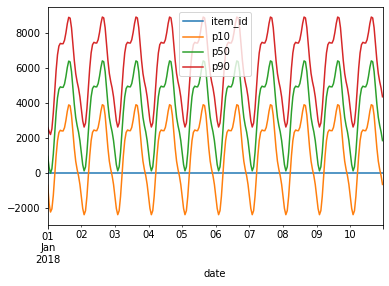

In [44]:
arima_predicts.plot()

In [45]:
print (arima_predicts.index.min())
print (arima_predicts.index.max())

2018-01-01 00:00:00
2018-01-10 23:00:00


Here we can see our prediction goes from Jan 01 to Jan 10 as expectged given our 240 interval forecast horizon. Also we can see the cyclical nature of the predictions over. the entire timeframe. 

Now we are going to create a dataframe of the prediction values from this Forecast and the actual values.

First let us remove the column ID of item before continuing.

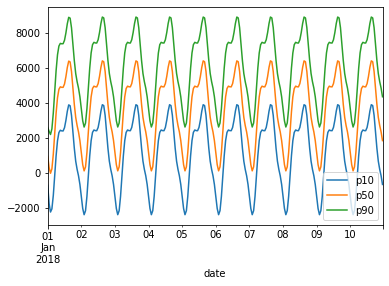

In [46]:
arima_predicts = arima_predicts[['p10', 'p50', 'p90']]
arima_predicts.plot()

2018-01-01 00:00:00
2018-01-10 23:00:00


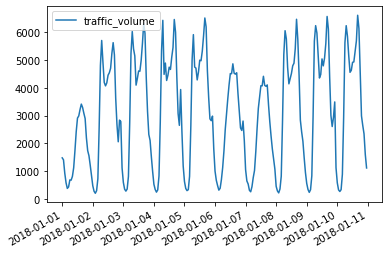

In [47]:
# Lets slice validation to meet our needs
validation_df = validation_time_series_df.copy()
validation_df = validation_df.loc['2018-01-01':'2018-01-10']
print (validation_df.index.min())
print (validation_df.index.max())
validation_df.plot()

In [48]:
# Finally let us join the dataframes together
arima_val_df = arima_predicts.join(validation_df, how='outer')

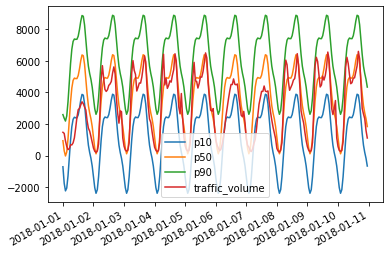

In [49]:
# Plot
arima_val_df.plot()

Given that this particular plot is hard to see, let us pick a random day January 5th to compare.

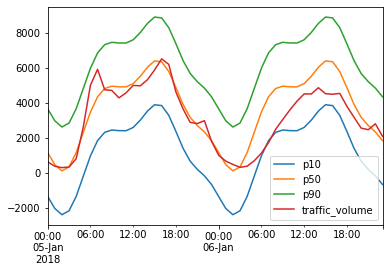

In [50]:
arima_val_df_jan_5 = arima_val_df.loc['2018-01-05':'2018-01-06']
arima_val_df_jan_5.plot()

Now this is pretty clear for p50 showcasing that it does a great job of predicting the volume. Let us now do this for Prophet and DeepAR+.

### Prophet Validation

We will speed up the prep work to just a few cells this time.

In [51]:
# Prophet Eval
prophet_predicts = pd.read_csv(data_dir+"/"+prophet_filename)
prophet_predicts.sample()
# Remove the timezone
prophet_predicts['date'] = pd.to_datetime(prophet_predicts['date'])
prophet_predicts['date'] = prophet_predicts['date'].dt.tz_convert(None)
prophet_predicts.set_index('date', inplace=True)
prophet_predicts = prophet_predicts[['p10', 'p50', 'p90']]
# Finally let us join the dataframes together
prophet_val_df = prophet_predicts.join(validation_df, how='outer')

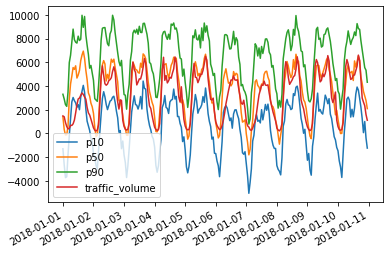

In [52]:
# Plot
prophet_val_df.plot()

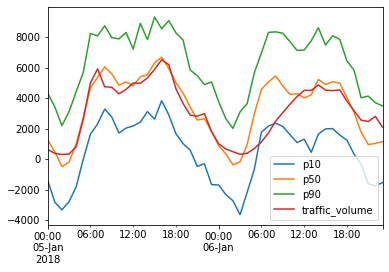

In [53]:
prophet_val_df_jan_5 = prophet_val_df.loc['2018-01-05':'2018-01-06']
prophet_val_df_jan_5.plot()

### CNN-QR Validation

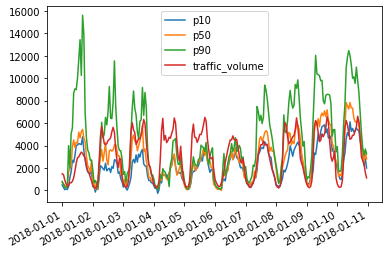

In [56]:
# CNN-QR Eval
cnnqr_predicts = pd.read_csv(data_dir + "/" + cnnqr_filename)
cnnqr_predicts.sample()
# Remove the timezone
cnnqr_predicts["date"] = pd.to_datetime(cnnqr_predicts["date"])
cnnqr_predicts["date"] = cnnqr_predicts["date"].dt.tz_convert(None)
cnnqr_predicts.set_index("date", inplace=True)
cnnqr_predicts = cnnqr_predicts[["p10", "p50", "p90"]]
# Finally let us join the dataframes together
cnnqr_val_df = cnnqr_predicts.join(validation_df, how="outer")
cnnqr_val_df.plot()

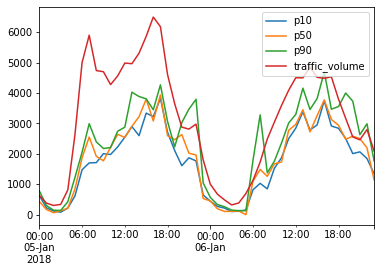

In [57]:
cnnqr_val_df_jan_5 = cnnqr_val_df.loc["2018-01-05":"2018-01-06"]
cnnqr_val_df_jan_5.plot()

What is particularly interesting here is that we were below the actual numbers for a good portion of the day even with p90. We did see great performance from Prophet and the metrics indicate that DeepAR+ is objectively better here so now we will add related time series data to our project and see how the models behave then.

## Recap and Next Steps

At this point we can now see through the 3 plots below that DeepAR+ does a really good job outside of the high ranges, and that perhaps adding related data could improve both Prophet and DeepAR+'s performance. The next thing to do is to move to the notebook for importing your related-time series data and then progress to the second Creating and Evaluating notebook that will explain how to leverage the related data.

In [58]:
%store markdown_results

Stored 'markdown_results' (list)
